In [2]:
from hydra.core.global_hydra import GlobalHydra
from hydra import initialize_config_dir, compose
import pandas as pd
from pathlib import Path
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np
import json
import random

# Initialize Hydra with the config path
GlobalHydra.instance().clear()
initialize_config_dir(config_dir="/home/ta-tldr/Project/tldr/config/", version_base=None)
cfg = compose(config_name="TrafficQA.yaml")
dataset_root = cfg.TrafficQA.dataset_root
video_root = dataset_root + "raw_videos/"

# per_token = True
per_token = False

# load csv file
df_info = pd.read_csv(Path(dataset_root, "csv", "response_mutual_info_text_task.csv"), delimiter="|")
df_comp = pd.read_csv(Path(dataset_root, "csv", "response_mutual_info_video_text.csv"), delimiter="|")
CoT_df_info = pd.read_csv(Path(dataset_root, "csv", "CoT_mutual_info_text_task.csv"), delimiter="|")
CoT_df_comp = pd.read_csv(Path(dataset_root, "csv", "CoT_mutual_info_video_text.csv"), delimiter="|")

# Read dataset annotations
traffic_dataset = pd.read_json('/nas/pohan/datasets/SUTDTrafficQA/annotations/R2_all.jsonl', lines=True)
traffic_dataset = pd.DataFrame(traffic_dataset.values[1:], columns=traffic_dataset.iloc[0]) # use first row as header

In [3]:
# Filter out rows with -10 in logprob_text or logprob
def filter_logprob(df_info, threshold=-10):
    return set(df_info[(df_info['logprob_text'] > threshold) & (df_info['logprob'] > threshold)]['record_id'])

# Apply the function to each dataframe
filtered_record_ids = (filter_logprob(df_info) & filter_logprob(CoT_df_info))
df_info_filtered = df_info[df_info['record_id'].isin(filtered_record_ids)]
CoT_info_filtered = CoT_df_info[CoT_df_info['record_id'].isin(filtered_record_ids)]

def calculate_tldr_scores(df_info):
    log_info_scores = []
    info_ranks = []
    for record_id in filtered_record_ids:
        row = df_info[df_info['record_id'] == record_id]
        info_score = row['informativeness_score'].values[0]
        log_info_scores.append(info_score)
        info_ranks.append(row["logprob_text"].values[0] - row["logprob"].values[0])
    return log_info_scores, info_ranks

log_info_scores, info_ranks = calculate_tldr_scores(df_info)
CoT_log_info_scores, CoT_info_ranks = calculate_tldr_scores(CoT_df_info)

# print the min and max rows (video_id) of informativeness scores
print("min informativeness: ", df_info_filtered[df_info_filtered['informativeness_score'] == min(log_info_scores)]['record_id'].values[0])
print("max informativeness: ", df_info_filtered[df_info_filtered['informativeness_score'] == max(log_info_scores)]['record_id'].values[0])
print("min CoT informativeness: ", CoT_info_filtered[CoT_info_filtered['informativeness_score'] == min(CoT_log_info_scores)]['record_id'].values[0])
print("max CoT informativeness: ", CoT_info_filtered[CoT_info_filtered['informativeness_score'] == max(CoT_log_info_scores)]['record_id'].values[0])

min informativeness:  47113
max informativeness:  51422
min CoT informativeness:  30250
max CoT informativeness:  6414


In [4]:
def initialize_dataframe():
    columns = ['video_id', 'group', 'predicted_word_video', 'predicted_word', 'orig_word', 'complexity_score', 'rank_video', 'rank']
    dtypes = {
        'video_id': 'int', 
        'group': 'object',
        'predicted_word_video': 'object',
        'predicted_word': 'object',        
        'orig_word': 'object',             
        'complexity_score': 'float', 
        'rank_video': 'object',            
        'rank': 'object'                   
    }
    return pd.DataFrame(columns=columns).astype(dtypes)

def process_data(df_info_filtered, df_comp):
    df_comp_total = initialize_dataframe()
    log_comp_scores = []
    comp_ranks = []
    max_id, min_id = None, None
    max_diff, min_diff = -100, 100
    num_tokens = []
    # Filter out rows with -10 in logprob_video or logprob
    for video_id in df_info_filtered['video_id'].unique():
        for group in df_comp['group'].unique():
            row = df_comp[(df_comp['video_id'] == video_id) & (df_comp['group'] == group)]
            if per_token:
                diff_count = len(row)
            else:
                diff_count = 1  # Placeholder value
            diff = row['diff'].sum()
            if diff == 0:
                print(f"Diff is 0 for video_id: {video_id}, group: {group}. This might be due to no video.")
                comp_ranks.append(0)
                num_tokens.append(1)
            else:
                log_comp_scores.append(diff / diff_count)
                comp_ranks.append(row['logprob_video'].values[0] - row['logprob'].values[0])
                num_tokens.append(diff_count)
                
            if diff > max_diff:
                max_diff = diff
                max_id = video_id
            if diff < min_diff:
                min_diff = diff
                min_id = video_id
            
            new_row = pd.DataFrame({
                'video_id': [video_id], 
                'group': [group],
                'predicted_word_video': [row['predicted_word_video'].values], 
                'predicted_word': [row['predicted_word'].values], 
                'orig_word': [row['orig_word'].values], 
                'complexity_score': [diff / diff_count], 
                'rank_video': [row['rank_video'].values], 
                'rank': [row['rank'].values]
            })
            df_comp_total = pd.concat([df_comp_total, new_row], ignore_index=True)
    
    return df_comp_total, log_comp_scores, comp_ranks, max_id, min_id, num_tokens


# Process data
df_comp_total, log_comp_scores, comp_ranks, max_id, min_id, num_tokens = process_data(df_info_filtered, df_comp)
CoT_df_comp_total, CoT_log_comp_scores, CoT_comp_ranks, CoT_max_id, CoT_min_id, CoT_num_tokens = process_data(df_info_filtered, CoT_df_comp)

print(f"Max complexity id: {max_id}, Min complexity id: {min_id}")
print(f"Max CoT complexity id: {CoT_max_id}, Min CoT complexity id: {CoT_min_id}")
print(f"Avg num of tokens: {sum(num_tokens) / len(num_tokens)}")
df_comp_total.head()


Diff is 0 for video_id: 23456, group: temperature_1.25. This might be due to no video.
Diff is 0 for video_id: 25722, group: temperature_1.5. This might be due to no video.
Max complexity id: 17688, Min complexity id: 6787
Max CoT complexity id: 23046, Min CoT complexity id: 13213
Avg num of tokens: 1.0


,video_id,group,predicted_word_video,predicted_word,orig_word,complexity_score,rank_video,rank
0,18542,temperature_0.0,"[night, control, ca, control, park, damage, dr...","[night, control, ca, control, park, damage, dr...","[night, control, causing, control, parked, dam...",0.381007,"[1, 1, 1, 1, 1, 1, 1, -1]","[1, 1, 1, 1, 1, 1, 1, -1]"
1,18542,temperature_0.5,"[control, h, park, driver, driver]","[control, h, park, driver, driver]","[control, hitting, parked, driver, driver]",-2.660343,"[1, 1, 1, 2, 1]","[1, 1, 1, 2, 1]"
2,18542,temperature_1.0,"[night, control, park, ca, damage, driver, dri...","[night, control, park, ca, damage, driver, dri...","[night, control, parked, causing, damage, driv...",-1.030940,"[1, 1, 1, 1, 1, 2, 1]","[1, 1, 1, 1, 1, 2, 1]"
3,18542,temperature_1.25,"[driver, control, park, hit, park, driver, dri...","[driver, control, park, hit, park, driver, dri...","[driver, control, parked, hit, parked, driver,...",0.913675,"[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 2, 1, 1, 1]"
4,18542,temperature_1.5,"[driver, control, park, driver, hit, ca, turn,...","[driver, control, park, driver, hit, ca, turni...","[driver, control, parked, driver, hit, causing...",0.673213,"[1, 1, 1, 4, 1, 1, 18, 1]","[1, 1, 1, 3, 1, 1, -1, 1]"


In [5]:
# Add a 'group' column to each DataFrame before concatenation
merged_info_df = df_info_filtered.copy().drop(columns=["predicted_answer_text", "predicted_answer"])

# Sort the merged DataFrame by 'video_id'
merged_info_df = merged_info_df.sort_values(by=['record_id', 'group'])

# print(f"merged_info_df shape: {merged_info_df.shape}")
# print(merged_info_df.head())

# Create a new DataFrame with selected columns
merge_record_info_df = pd.DataFrame({
    'video_id': pd.Series(dtype='int'),
    'group': pd.Series(dtype='object'),
    'max_informativeness_score': pd.Series(dtype='float64'),
    'min_informativeness_score': pd.Series(dtype='float64'),
    'informativeness_score': pd.Series(dtype='float64')
})

cnt = 0
for video_id in merged_info_df['video_id'].unique():
    for group in merged_info_df['group'].unique():
        row = merged_info_df[(merged_info_df['video_id'] == video_id) & (merged_info_df['group'] == group)]
        if not row.empty:
            merge_record_info_df.at[cnt, 'video_id'] = int(video_id)
            merge_record_info_df.at[cnt, 'group'] = group
            merge_record_info_df.at[cnt, 'max_informativeness_score'] = max(row['informativeness_score'].values)
            merge_record_info_df.at[cnt, 'min_informativeness_score'] = min(row['informativeness_score'].values)
            merge_record_info_df.at[cnt, 'informativeness_score'] = sum(row['informativeness_score'].values) / len(row['informativeness_score'].values)
            cnt += 1

merge_record_info_df = merge_record_info_df.sort_values(by=['video_id', 'group'])
merge_record_info_df['video_id'] = merge_record_info_df['video_id'].astype(int)
print(f"new_info_df shape: {merge_record_info_df.shape}\n")
merge_record_info_df.head()

new_info_df shape: (500, 5)



,video_id,group,max_informativeness_score,min_informativeness_score,informativeness_score
65,2058,temperature_0.0,2.356145,-0.280104,0.430201
66,2058,temperature_0.5,2.140882,0.000755,0.697451
67,2058,temperature_1.0,2.241530,0.000755,0.774625
68,2058,temperature_1.25,1.870146,0.000734,0.514800
69,2058,temperature_1.5,2.072885,-0.000942,0.687235


In [6]:
# then concatenate as before
merged_complexity_df = df_comp_total.sort_values(by=['video_id', 'group'])
merged_complexity_df.drop(columns=['predicted_word_video', 'predicted_word', 'orig_word', 'rank_video', 'rank'], inplace=True)
print(f"merged_complexity_df shape: {merged_complexity_df.shape}")
merged_complexity_df.head()

merged_complexity_df shape: (500, 3)


,video_id,group,complexity_score
400,2058,temperature_0.0,0.069591
401,2058,temperature_0.5,-4.592310
402,2058,temperature_1.0,5.529717
403,2058,temperature_1.25,5.012994
404,2058,temperature_1.5,4.071941


In [7]:
# merge the rows of the two dataframes with the same video_id and group
ib_df = pd.merge(merged_complexity_df, merge_record_info_df, on=['video_id', 'group'], how='inner')
ib_df = ib_df.sort_values(['video_id', 'group'], ascending=True)

# create a new column for the informativeness score difference for each beta
alpha_betas = [(1, 0), (-1, 0), (0, 1)]
alpha_betas += [(-0.02, 1), (-0.05, 1), (-0.1, 1), (-0.3, 1)]
alpha_betas += [(0.02, 1), (0.05, 1), (0.1, 1), (0.3, 1)]
max_ib_dfs = []
max_ib_labels = []
for idx, ab in enumerate(alpha_betas):
    a, b = ab
    max_ib_labels.append(f'Max IB ($\\alpha,\\beta=({a},{b})$)')
    ib_df[f'ib_score_beta_{ab}'] = a * ib_df['complexity_score'] + b * ib_df['informativeness_score']
    # ascending=False to get the max score
    max_ib_dfs.append(ib_df.sort_values(f'ib_score_beta_{ab}', ascending=False).drop_duplicates('video_id').reset_index(drop=True))
    ib_df.drop(columns=[f'ib_score_beta_{ab}'], inplace=True)
print(max_ib_dfs[-1].shape)
print(max_ib_dfs[-1].head())

# randomly sample ib scores
random.seed(42)
ib_df["random_score"] = np.random.randint(0, 1000, len(ib_df))
# ascending=False to get the max score
max_ib_dfs.append(ib_df.sort_values('random_score', ascending=False).drop_duplicates('video_id').reset_index(drop=True))
ib_df.drop(columns=['random_score'], inplace=True)
print(max_ib_dfs[-1].shape)
print(max_ib_dfs[-1].head())

(100, 7)
   video_id             group  complexity_score  max_informativeness_score  \
0     17688   temperature_1.5         28.443883                   0.360375   
1     30667   temperature_0.5         17.198156                   1.062447   
2      2728  temperature_1.25         15.569460                   0.046076   
3     16073   temperature_0.5          8.102525                   6.133470   
4     23474   temperature_0.0         11.261176                   0.947582   

   min_informativeness_score  informativeness_score  ib_score_beta_(0.3, 1)  
0                  -4.018224              -1.053491                7.479674  
1                  -1.062773               0.248095                5.407541  
2                  -0.812988              -0.360001                4.310837  
3                  -0.262958               1.469814                3.900572  
4                   0.058888               0.374597                3.752950  
(100, 7)
   video_id             group  complexity_sco

In [8]:
visible = {
    # 'TLDR': True,
    # 'Abstract': True,
    # 'VLM (Aware)': True,
    # 'VLM (Agnostic)': True,
    'CoT': True
}
for label in max_ib_labels:
    visible[label] = True
visible["random"] = True

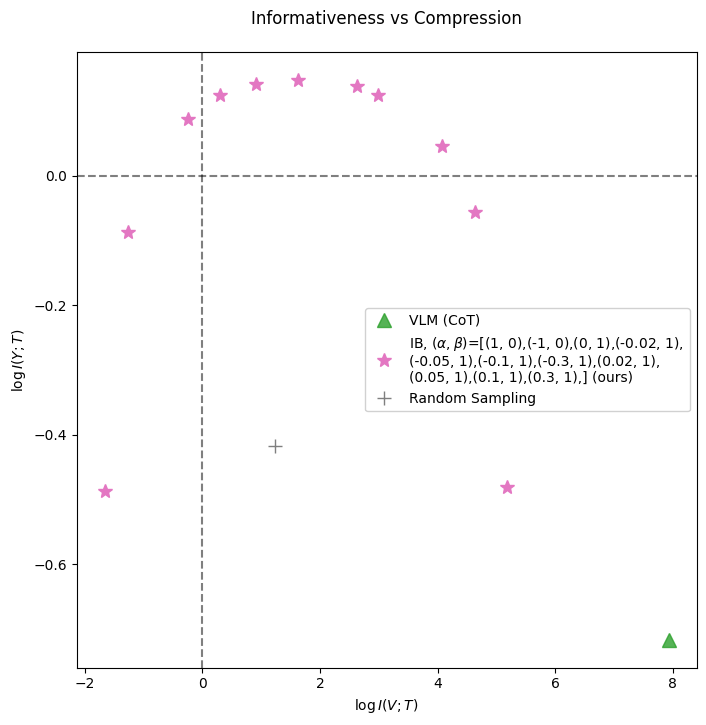

In [9]:
# Create a figure for the main scatter plot
fig, scatter_ax = plt.subplots(figsize=(8, 8))

# Create a custom color palette for better distinction
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#d62728', '#e377c2', '#7f7f7f']
markers = ['o', 's', '^', 'd', 'x', 'P', '*', '+']
opacity = [0.8, 0.8, 0.8, 0.8, 1, 1, 1, 1]
data_groups = {
    'CoT': {
        'x': CoT_log_comp_scores,
        'y': CoT_log_info_scores,
        'color': colors[2],
        'marker': markers[2],
        'alpha': opacity[2]
    },
}
for idx, label in enumerate(max_ib_labels):
    data_groups[label] = {
        'x': max_ib_dfs[idx]['complexity_score'],
        'y': max_ib_dfs[idx]['informativeness_score'],
        'color': colors[6],
        'marker': markers[6],
        'alpha': opacity[6]
    }
data_groups["random"] = {
        'x': max_ib_dfs[-1]['complexity_score'],
        'y': max_ib_dfs[-1]['informativeness_score'],
        'color': colors[7],
        'marker': markers[7],
        'alpha': opacity[7]
    }

# Create scatter plots and error bars for each group
ib_legend = False
for label, group_data in data_groups.items():
    if label == 'CoT':
        label_latex = "VLM (CoT)"
    elif label == 'random':
        label_latex = "Random Sampling"
    elif "Max IB" in label and not ib_legend:
        label_latex = "IB, $(\\alpha, \\beta)$=["
        for idx, ab in enumerate(alpha_betas):
            label_latex += f"{ab},"
            if idx % 4 == 3:
                label_latex += '\n'
        label_latex += "] (ours)"
        ib_legend = True
    else:
        label_latex = ""

    # Main scatter plot with error bars
    scatter_ax.errorbar(
        np.mean(group_data['x']), np.mean(group_data['y']),
        fmt=group_data['marker'], color=group_data['color'], 
        elinewidth=1.5, capsize=8, alpha=group_data['alpha'], label=label_latex,
        markersize=10  # Increased marker size
    ) if visible[label] else None

# Add x=0 and y=0 lines
scatter_ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.set_xlabel('$\log I(V;T)$ ')  # Negative complexity score
scatter_ax.set_ylabel('$\log I(Y;T)$ ')  # Informativeness score
scatter_ax.set_title('Informativeness vs Compression', pad=20)

# Add a vertical arrow pointing upwards with text above it
scatter_ax.annotate('More\nInformative',
                    xy=(3.5, 3.75),  # Arrow tip
                    xytext=(3.5, 1.5),  # Arrow tail (lower position for upward direction)
                    arrowprops=dict(color='black', arrowstyle='-|>', lw=2),
                    fontsize=10, color='red',
                    ha='center',  # Center text horizontally
                    va='bottom')  # Ensure text is above the arrow

# Add a horizontal arrow pointing left with text above it
scatter_ax.annotate('More Grounded to Video',
                    xy=(30, 3.5),  # Arrow tip (further left)
                    xytext=(15, 3.5),  # Arrow tail (even further left)
                    arrowprops=dict(color='black', arrowstyle='-|>', lw=2),
                    fontsize=10, color='red',
                    ha='center',  # Align text to the right (places it left of the arrow)
                    va='center')  # Vertically center the text

# Add legend
scatter_ax.legend(frameon=True, framealpha=0.9, loc='best')

plt.show()

### Length vs. Informativeness

In [10]:
# load response length data
length_df = pd.read_csv(Path(dataset_root, "csv", "vlm_response_length.csv")) #.drop(columns=["response"])
CoT_length_df = pd.read_csv(Path(dataset_root, "csv", "vlm_CoT_length.csv")) #.drop(columns=["response"])
# IB filtering
length_ib_dfs = []
for idx, ab in enumerate(alpha_betas):
    length_df = pd.merge(length_df, max_ib_dfs[idx][['video_id', f'ib_score_beta_{ab}']], on='video_id', how='inner')
    length_ib_dfs.append(length_df.sort_values(f'ib_score_beta_{ab}', ascending=False).drop_duplicates('video_id').reset_index(drop=True))
    length_df.drop(columns=[f'ib_score_beta_{ab}'], inplace=True)

In [11]:
# save the best responses of each openreview ID according to the following criteria:
# 1. max informativeness score
# 2. max complexity score
# 3. min informativeness score
# 4. min complexity score


# Save the best responses based on the criteria
best_responses = {}

# 1. Max informativeness score
best_responses['max_informativeness'] = merged_info_df.loc[
    merged_info_df.groupby('video_id')['informativeness_score'].idxmax()
].drop(columns=['correct_answer', 'logprob_text', 'logprob', 'rank_text', 'rank'])

# 2. Max complexity score
best_responses['max_complexity'] = merged_complexity_df.loc[
    merged_complexity_df.groupby('video_id')['complexity_score'].idxmax()
]

# 3. Min informativeness score
best_responses['min_informativeness'] = merged_info_df.loc[
    merged_info_df.groupby('video_id')['informativeness_score'].idxmin()
].drop(columns=['correct_answer', 'logprob_text', 'logprob', 'rank_text', 'rank'])

# 4. Min complexity score
best_responses['min_complexity'] = merged_complexity_df.loc[
    merged_complexity_df.groupby('video_id')['complexity_score'].idxmin()
]

print("Best responses based on criteria:")
print("Max Informativeness:\n", best_responses["max_informativeness"].head())
print("Max Complexity:\n", best_responses["max_complexity"].head())
print("Min Informativeness:\n", best_responses["min_informativeness"].head())
print("Min Complexity:\n", best_responses["min_complexity"].head())

Best responses based on criteria:
Max Informativeness:
       video_id  record_id               vid_filename               q_type  \
2805      2058       1283  b_1Gb411G7XZ_clip_004.mp4  Basic Understanding   
1509      2263      28472  b_194411y72B_clip_001.mp4  Basic Understanding   
2393      2638      50925  b_1764y1M7zr_clip_032.mp4  Basic Understanding   
1133      2728      47135  b_1hE411k7re_clip_014.mp4  Basic Understanding   
76        2760      15710  b_1at411y7Eo_clip_007.mp4  Basic Understanding   

                 group  informativeness_score  
2805   temperature_0.0               2.356145  
1509  temperature_1.25               1.397923  
2393   temperature_0.5               3.893809  
1133   temperature_0.0               0.725900  
76     temperature_0.5               1.010505  
Max Complexity:
      video_id             group  complexity_score
402      2058   temperature_1.0          5.529717
218      2263  temperature_1.25          2.162583
341      2638   temperatur

In [12]:
# Add the parent directory to sys.path to make utils module accessible
import sys
sys.path.append(str(Path.cwd().parent.parent))
from utils.primary_area import subarea_map
OPTIONS = sorted(list(set(subarea_map.values())))

# save all the responses from best_responses
id2_responses_json = {}
for idx, row in length_df.iterrows():
    video_id = row['video_id']
    video_id = row['video_id']
    if video_id not in id2_responses_json:
        id2_responses_json[video_id] = {}
    for key, best_df in best_responses.items():
        group = best_df[best_df['video_id'] == video_id]['group'].values[0]
        id2_responses_json[video_id][key] = length_df[
            (length_df['video_id'] == video_id) & 
            (length_df['group'] == group)
        ]["response"].values[0]
    correct_option =  merged_info_df[
        merged_info_df['video_id'] == video_id
    ]["correct_answer"].values[0]
    correct_number = ord(correct_option) - ord('A')
    id2_responses_json[video_id]["correct_answer"] = OPTIONS[correct_number]
    id2_responses_json[video_id]['video_id'] = video_id

# save the json file
with open(Path(video_root, "best_responses.json"), 'w') as f:
    json.dump(id2_responses_json, f, indent=4)

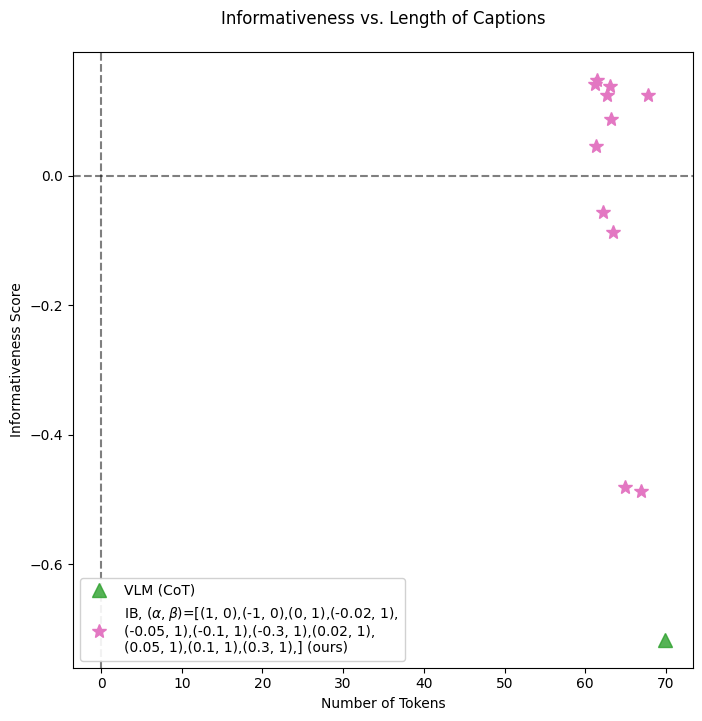

In [13]:
# Define data groups
data_groups_length = {
    'CoT': {
        'x': CoT_length_df['length'],
        'y': CoT_log_info_scores,
        'color': colors[2],
        'marker': markers[2],
        'alpha': opacity[2]
    },
}
for idx, label in enumerate(max_ib_labels):
    data_groups_length[label] = {
        'x': length_ib_dfs[idx]['length'],
        'y': max_ib_dfs[idx]['informativeness_score'],
        'color': colors[6],
        'marker': markers[6],
        'alpha': opacity[6]
    }

# Create a grid layout without space for histograms
fig, scatter_ax = plt.subplots(figsize=(8, 8))

ib_legend = False
for label, group_data in data_groups_length.items():
    if label == 'CoT':
        label_latex = "VLM (CoT)"
    elif label in ['VLM (Agnostic)', 'VLM (Aware)']:
        label_latex = label
    elif label in ['TLDR', 'Abstract']:
        label_latex = label + " (OpenReview)"
    elif "Max IB" in label and not ib_legend:
        label_latex = "IB, $(\\alpha, \\beta)$=["
        for idx, ab in enumerate(alpha_betas):
            label_latex += f"{ab},"
            if idx % 4 == 3:
                label_latex += '\n'
        label_latex += "] (ours)"
        ib_legend = True
    else:
        label_latex = ""

    # Main scatter plot
    scatter_ax.errorbar(
        np.mean(group_data['x']), np.mean(group_data['y']),
        fmt=group_data['marker'], color=group_data['color'],
        elinewidth=1.5, capsize=8, alpha=group_data['alpha'], label=label_latex,
        markersize=10  # Increased marker size
    ) if visible[label] else None

# Add x=0 and y=0 lines
scatter_ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.set_xlabel('Number of Tokens')
scatter_ax.set_ylabel('Informativeness Score')
scatter_ax.set_title('Informativeness vs. Length of Captions', pad=20)

# Add legend
scatter_ax.legend(frameon=True, framealpha=0.9, loc='lower left')
plt.show()


In [14]:
# calculate accuracy
acc_df = pd.read_csv(Path(dataset_root, "csv", "vlm_CoT.csv"), delimiter="|")
acc = []
for idx, row in acc_df.iterrows():
    vlm_answer = row['vlm_answer'].split('(')[-1].split(')')[0]
    answer = chr(65 + int(row['answer']))
    acc.append(vlm_answer == answer)

accuracy = sum(acc) / len(acc) if acc else 0
print(f"Overall accuracy: {accuracy}")

Overall accuracy: 0.6294706723891274


## construct sample10 stimulus

In [15]:
# read in response data
cot_responses_df = pd.read_csv('/nas/pohan/datasets/SUTDTrafficQA/csv/vlm_CoT.csv', delimiter='|')
vlm_responses_df = pd.read_csv('/nas/pohan/datasets/SUTDTrafficQA/csv/vlm_responses.csv', delimiter='|')

In [16]:
stimulus_df = pd.DataFrame(columns=['video_id', 'record_id', 'q_type', 'question', 'option0', 'option1', 'option2', 'option3', 'vid_filename', 'answer', 'vlm_reasoning', 'vlm_answer'])

for i, id in enumerate(df_info_filtered['video_id'].unique()):
    # print(f"{i+1}/{len(df_info_filtered['video_id'].unique())} {id}")

    data = df_info_filtered[df_info_filtered['video_id'] == id]
    for idx, row in data.iterrows():
        record_id = row['record_id']
        traffic_data = traffic_dataset[(traffic_dataset['vid_filename'] == row['vid_filename']) & (traffic_dataset['record_id'] == record_id)]
        cot_data = cot_responses_df[(cot_responses_df['vid_filename'] == row['vid_filename']) & (cot_responses_df['record_id'] == record_id)]
        new_row = {
            'video_id': row['video_id'],
            'record_id': record_id,
            'q_type': row['q_type'],
            'question': traffic_data['q_body'].values[0],
            'option0': traffic_data['option0'].values[0],
            'option1': traffic_data['option1'].values[0],
            'option2': traffic_data['option2'].values[0],
            'option3': traffic_data['option3'].values[0],
            'vid_filename': row['vid_filename'],
            'answer': traffic_data['answer'].values[0],
            'vlm_reasoning': cot_data['vlm_reasoning'].values[0],
            'vlm_answer': cot_data['vlm_answer'].values[0]
        }
        stimulus_df = pd.concat([stimulus_df, pd.DataFrame([new_row])], ignore_index=True)

stimulus_df.head()

,video_id,record_id,q_type,question,option0,option1,option2,option3,vid_filename,answer,vlm_reasoning,vlm_answer
0,18542,5202,Basic Understanding,Was there any police car around?,No,,Yes,,b_1B4411M7a6_clip_046.mp4,0,The video shows a sequence of events where a c...,(A) No
1,18542,29776,Basic Understanding,What is the type of vehicles present in this v...,Truck,Bicycle,Bus,Car,b_1B4411M7a6_clip_046.mp4,3,The video shows a white car driving erraticall...,(D)
2,18542,54755,Basic Understanding,Are there any cars signalling left or right turn?,,,Yes,No,b_1B4411M7a6_clip_046.mp4,3,"To answer this question, I need to analyze the...",(D) No
3,18542,30252,Basic Understanding,Were the vehicles close to each other in the v...,,No,Yes,,b_1B4411M7a6_clip_046.mp4,2,The video shows a car driving erratically and ...,(C) Yes
4,18542,48295,Basic Understanding,Did a car surpass another car in the video?,,No,Yes,,b_1B4411M7a6_clip_046.mp4,1,The video shows a car driving erratically and ...,(B) No


In [17]:
# add a column to indicate if vlm_answer matches the correct answer
# map A, B, C, D to 0, 1, 2, 3
answer_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
# Extract the letter from the vlm_answer (format like "(A)" or "(A) text...")
# Fix the error: 'list' object has no attribute 'str'
# Process each element individually
processed_answers = []
for answer in stimulus_df['vlm_answer']:
    if isinstance(answer, str):
        # Extract the first part and remove parentheses
        first_part = answer.split(' ')[0].strip('()').upper()
        # Map to numeric value
        processed_answers.append(answer_map.get(first_part, None))
    else:
        processed_answers.append(None)

stimulus_df['vlm_answer_processed'] = processed_answers
stimulus_df['ans_match'] = stimulus_df['vlm_answer_processed'] == stimulus_df['answer']
stimulus_df.drop(columns=['vlm_answer_processed'], inplace=True)

stimulus_df.head()

,video_id,record_id,q_type,question,option0,option1,option2,option3,vid_filename,answer,vlm_reasoning,vlm_answer,ans_match
0,18542,5202,Basic Understanding,Was there any police car around?,No,,Yes,,b_1B4411M7a6_clip_046.mp4,0,The video shows a sequence of events where a c...,(A) No,True
1,18542,29776,Basic Understanding,What is the type of vehicles present in this v...,Truck,Bicycle,Bus,Car,b_1B4411M7a6_clip_046.mp4,3,The video shows a white car driving erraticall...,(D),True
2,18542,54755,Basic Understanding,Are there any cars signalling left or right turn?,,,Yes,No,b_1B4411M7a6_clip_046.mp4,3,"To answer this question, I need to analyze the...",(D) No,True
3,18542,30252,Basic Understanding,Were the vehicles close to each other in the v...,,No,Yes,,b_1B4411M7a6_clip_046.mp4,2,The video shows a car driving erratically and ...,(C) Yes,True
4,18542,48295,Basic Understanding,Did a car surpass another car in the video?,,No,Yes,,b_1B4411M7a6_clip_046.mp4,1,The video shows a car driving erratically and ...,(B) No,True


In [18]:
# continue filtering the out dataframe to get exactly 4 questions per video
# aiming for 3 correct and 1 incorrect answers per video when possible

# Group by video_id to find all videos
video_groups = stimulus_df.groupby('video_id')

# Initialize an empty dataframe to store our results
final_out = pd.DataFrame()

for video_id, group in video_groups:
    # Get questions with correct answers
    correct_answers = group[group['ans_match'] == True]
    
    # Get questions with incorrect answers
    incorrect_answers = group[group['ans_match'] == False]
    
    # Case 1: Ideal case - at least 3 correct and 1 incorrect
    if len(correct_answers) >= 3 and len(incorrect_answers) >= 1:
        selected_correct = correct_answers.head(3)
        selected_incorrect = incorrect_answers.head(1)
        selected = pd.concat([selected_correct, selected_incorrect])
    
    # Case 2: Not enough incorrect answers (4+ correct, 0 incorrect)
    elif len(correct_answers) >= 4 and len(incorrect_answers) == 0:
        selected = correct_answers.head(4)
    
    # Case 3: Not enough correct answers (0-2 correct)
    elif len(correct_answers) < 3:
        # Take all available correct answers
        selected = correct_answers
        # Fill the rest with incorrect answers
        needed = 4 - len(selected)
        if len(incorrect_answers) >= needed:
            selected = pd.concat([selected, incorrect_answers.head(needed)])
        else:
            # Not enough questions in total
            continue
    
    # Case 4: Exactly 3 correct, 0 incorrect
    elif len(correct_answers) == 3 and len(incorrect_answers) == 0:
        # Not enough questions in total
        continue
    
    # Only include this video if we have exactly 4 questions
    if len(selected) == 4:
        final_out = pd.concat([final_out, selected])

# Sort by video_id for better organization
final_out = final_out.sort_values(by=['video_id', 'record_id'])

# calculate the accuracy of the final_out dataframe
num_correct_answers = len(final_out[final_out['ans_match'] == True])
num_total_answers = len(final_out)
accuracy = num_correct_answers / num_total_answers
print(f"Accuracy: {accuracy}")

final_out.head()

Accuracy: 0.83


,video_id,record_id,q_type,question,option0,option1,option2,option3,vid_filename,answer,vlm_reasoning,vlm_answer,ans_match
2215,2058,1283,Basic Understanding,Was the driver driving in the correct direction?,Yes,,,No,b_1Gb411G7XZ_clip_004.mp4,0,The video shows a nighttime scene with vehicle...,(A) Yes,True
2217,2058,27957,Basic Understanding,Was there any police officer nearby when the c...,Yes,No,,,b_1Gb411G7XZ_clip_004.mp4,1,The video shows a sequence of frames capturing...,(B) No,True
2216,2058,39332,Basic Understanding,Does the road have clear markings?,"Yes, but the markings are old or not very obvi...","No, the road is unmarked.","Yes, the road is marked clearly.",,b_1Gb411G7XZ_clip_004.mp4,2,"In the video, the road has visible white lines...","(A) Yes, but the markings are old or not very ...",False
2218,2058,55799,Basic Understanding,What's the time of the day?,Nighttime,,,Daytime,b_1Gb411G7XZ_clip_004.mp4,0,The video shows a dark sky with streetlights i...,(A) Nighttime,True
1134,2263,17925,Basic Understanding,Is there any vehicle rollover after crashing?,Yes,There is no accident.,,No,b_194411y72B_clip_001.mp4,0,The video starts with a graphical representati...,(D) No,False


In [19]:
# import os
# # Create directory if it doesn't exist
# os.makedirs('../../../user_study/trafficqa/data', exist_ok=True)
# # Save the file
# output_path = '../../../user_study/trafficqa/data/sampled_stimulus_100.csv'
# final_out.to_csv(output_path, index=False)
# print(f"File saved to: {os.path.abspath(output_path)}", flush=True)

## sample 10

In [20]:
# Load long videos and find those that are also in our filtered dataset
long_vid = pd.read_csv('long_videos.csv')
filtered_long_videos = df_info_filtered[df_info_filtered['vid_filename'].isin(long_vid['filename'])]

# Get videos with at least 4 unique record_ids
video_counts = filtered_long_videos.groupby('vid_filename')['record_id'].nunique()
eligible_videos = video_counts[video_counts >= 4].index.tolist()

# Get the 10 longest videos from eligible videos
eligible_long_vids = long_vid[long_vid['filename'].isin(eligible_videos)].sort_values('duration', ascending=False)
sampled_ids = eligible_long_vids['filename'].tolist()
sampled_vids = [filtered_long_videos[filtered_long_videos['vid_filename'] == video]['video_id'].values[0] for video in sampled_ids]

In [21]:
# expected dataframe
sample10_stimulus = pd.DataFrame(columns=['video_id', 'record_id', 'q_type', 'question', 'option0', 'option1', 'option2', 'option3', 'vid_filename', 'answer', 'vlm_reasoning', 'random_response', 'maxinfo_response', 'maxcomp_response'])

for id in sampled_ids:
    cot_data = cot_responses_df[cot_responses_df['vid_filename'] == id]
    
    for idx, row in cot_data.iterrows():
        record_id = row['record_id']
        traffic_data = traffic_dataset[(traffic_dataset['vid_filename'] == id) & (traffic_dataset['record_id'] == record_id)]
        new_row = {
            'video_id': row['video_id'],
            'record_id': record_id,
            'q_type': row['q_type'],
            'question': row['question'],
            'option0': traffic_data['option0'].values[0],
            'option1': traffic_data['option1'].values[0],
            'option2': traffic_data['option2'].values[0],
            'option3': traffic_data['option3'].values[0],
            'answer': row['answer'],
            'vid_filename': row['vid_filename'],
            'vlm_reasoning': row['vlm_reasoning'],
            'vlm_answer': row['vlm_answer']
        }
        sample10_stimulus = pd.concat([sample10_stimulus, pd.DataFrame([new_row])], ignore_index=True)

In [22]:
# traffic_scores = pd.DataFrame(columns=['group', 'video_id', 'record_id', 'infoscore', 'compscore'])

random_df = max_ib_dfs[-1]

for video_id in sampled_vids:
    # Get video data from random_df
    random_data = random_df[random_df['video_id'] == video_id]
    group = random_data['group'].values[0]
    temperature = float(group.split('_')[1])
    
    # Get response for this video and temperature
    response = vlm_responses_df[(vlm_responses_df['video_id'] == video_id) & 
                               (vlm_responses_df['temperature'] == temperature)]['response'].values[0]
    
    # Update all rows with this video_id
    sample10_stimulus.loc[sample10_stimulus['video_id'] == video_id, 'random_response'] = response

In [23]:
maxcomp_df = pd.DataFrame()
for i, label in enumerate(max_ib_labels):
    if label == 'Max IB ($\\alpha,\\beta=(1,0)$)':
        maxcomp_df = pd.concat([maxcomp_df, max_ib_dfs[i]], ignore_index=True)

for video_id in sampled_vids:
    maxcomp_data = maxcomp_df[maxcomp_df['video_id'] == video_id]
    group = maxcomp_data['group'].values[0]
    temperature = float(group.split('_')[1])

    # Get response for this video and temperature
    response = vlm_responses_df[(vlm_responses_df['video_id'] == video_id) & 
                               (vlm_responses_df['temperature'] == temperature)]['response'].values[0]
    
    # Update all rows with this video_id
    sample10_stimulus.loc[sample10_stimulus['video_id'] == video_id, 'maxcomp_response'] = response

In [24]:
maxinfo_df = pd.DataFrame()
for i, label in enumerate(max_ib_labels):
    if label == 'Max IB ($\\alpha,\\beta=(0,1)$)':
        maxinfo_df = pd.concat([maxinfo_df, max_ib_dfs[i]], ignore_index=True)

for video_id in sampled_vids:
    maxinfo_data = maxinfo_df[maxinfo_df['video_id'] == video_id]
    group = maxinfo_data['group'].values[0]
    temperature = float(group.split('_')[1])

    # Get response for this video and temperature
    response = vlm_responses_df[(vlm_responses_df['video_id'] == video_id) & 
                               (vlm_responses_df['temperature'] == temperature)]['response'].values[0]
    
    # Update all rows with this video_id
    sample10_stimulus.loc[sample10_stimulus['video_id'] == video_id, 'maxinfo_response'] = response

In [25]:
# # save to csv
# import os

# # Create directory if it doesn't exist
# output_dir = '../../../user_study/trafficqa/data'
# os.makedirs(output_dir, exist_ok=True)

# # Save to csv
# output_file = os.path.join(output_dir, 'sampled_stimulus_27.csv')
# sample10_stimulus.to_csv(output_file, index=False)

# # Print absolute path to make it easier to find
# abs_path = os.path.abspath(output_file)
# print(f"File saved to: {abs_path}")

In [26]:
# Filter videos where all three responses are different from each other
filtered_stimulus = sample10_stimulus.copy()

# Create a mask for videos where all three responses are different
mask = filtered_stimulus.apply(
    lambda row: (row['random_response'] != row['maxinfo_response']) and 
                (row['random_response'] != row['maxcomp_response']) and 
                (row['maxinfo_response'] != row['maxcomp_response']),
    axis=1
)

# Get the video_ids where all responses are different
diverse_video_ids = filtered_stimulus[mask]['video_id'].unique()

# If we want to prioritize these videos but still show all data
print(f"Found {len(diverse_video_ids)} videos with all different responses")

# Display the filtered data first, followed by the rest
diverse_data = filtered_stimulus[filtered_stimulus['video_id'].isin(diverse_video_ids)]
out = pd.concat([diverse_data, filtered_stimulus[~filtered_stimulus['video_id'].isin(diverse_video_ids)]])

# add a column to indicate if vlm_answer matches the correct answer
# map A, B, C, D to 0, 1, 2, 3
answer_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
# Extract the letter from the vlm_answer (format like "(A)" or "(A) text...")
# Fix the error: 'list' object has no attribute 'str'
# Process each element individually
processed_answers = []
for answer in out['vlm_answer']:
    if isinstance(answer, str):
        # Extract the first part and remove parentheses
        first_part = answer.split(' ')[0].strip('()').upper()
        # Map to numeric value
        processed_answers.append(answer_map.get(first_part, None))
    else:
        processed_answers.append(None)

out['vlm_answer_processed'] = processed_answers
out['ans_match'] = out['vlm_answer_processed'] == out['answer']
out.drop(columns=['vlm_answer_processed'], inplace=True)

out


# continue filtering the out dataframe to get exactly 4 questions per video
# aiming for 3 correct and 1 incorrect answers per video when possible

# Group by video_id to find all videos
video_groups = out.groupby('video_id')

# Initialize an empty dataframe to store our results
final_out = pd.DataFrame()

for video_id, group in video_groups:
    # Get questions with correct answers
    correct_answers = group[group['ans_match'] == True]
    
    # Get questions with incorrect answers
    incorrect_answers = group[group['ans_match'] == False]
    
    # Case 1: Ideal case - at least 3 correct and 1 incorrect
    if len(correct_answers) >= 3 and len(incorrect_answers) >= 1:
        selected_correct = correct_answers.head(3)
        selected_incorrect = incorrect_answers.head(1)
        selected = pd.concat([selected_correct, selected_incorrect])
    
    # Case 2: Not enough incorrect answers (4+ correct, 0 incorrect)
    elif len(correct_answers) >= 4 and len(incorrect_answers) == 0:
        selected = correct_answers.head(4)
    
    # Case 3: Not enough correct answers (0-2 correct)
    elif len(correct_answers) < 3:
        # Take all available correct answers
        selected = correct_answers
        # Fill the rest with incorrect answers
        needed = 4 - len(selected)
        if len(incorrect_answers) >= needed:
            selected = pd.concat([selected, incorrect_answers.head(needed)])
        else:
            # Not enough questions in total
            continue
    
    # Case 4: Exactly 3 correct, 0 incorrect
    elif len(correct_answers) == 3 and len(incorrect_answers) == 0:
        # Not enough questions in total
        continue
    
    # Only include this video if we have exactly 4 questions
    if len(selected) == 4:
        final_out = pd.concat([final_out, selected])

# Sort by video_id for better organization
final_out = final_out.sort_values(by=['video_id', 'record_id'])

# calculate the accuracy of the final_out dataframe
num_correct_answers = len(final_out[final_out['ans_match'] == True])
num_total_answers = len(final_out)
accuracy = num_correct_answers / num_total_answers
print(f"Accuracy: {accuracy}")

# import os
# path = '../../../user_study/trafficqa/data/sampled_stimulus_75.csv'
# abs_path = os.path.abspath(path)
# final_out.to_csv(path, index=False)
# print(f"File saved to: {abs_path}", flush=True)

Found 15 videos with all different responses
Accuracy: 0.75


In [28]:
score_df = pd.read_csv('/nas/pohan/datasets/SUTDTrafficQA/csv/response_mutual_info_video_text_new4.csv', delimiter='|')
score_df

,video_id,vid_filename,group,predicted_word_video,predicted_word,orig_word,logprob_video,logprob,diff,rank_video,rank
0,2058,b_1Gb411G7XZ_clip_004.mp4,temperature_0.0,urban,urban,urban,-0.909418,-3.625546,2.716128,2,3
1,2058,b_1Gb411G7XZ_clip_004.mp4,temperature_0.0,white,white,white,-2.937255,-4.321824,1.384569,3,4
2,2058,b_1Gb411G7XZ_clip_004.mp4,temperature_0.0,ahead,ahead,ahead,-0.001461,-0.027477,0.026016,1,1
3,2058,b_1Gb411G7XZ_clip_004.mp4,temperature_0.0,smooth,smooth,smoothly,-0.001199,-0.003899,0.002699,1,1
4,2058,b_1Gb411G7XZ_clip_004.mp4,temperature_0.0,immediate,immediate,immediate,-10.000000,-10.000000,0.000000,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
2142,15796,b_1JE411r7ba_clip_007.mp4,temperature_1.25,right,right,right,-0.191579,-1.460369,1.268790,1,2
2143,15796,b_1JE411r7ba_clip_007.mp4,temperature_1.25,suggest,suggest,suggests,-2.836891,-0.689934,-2.146957,2,1
2144,15796,b_1JE411r7ba_clip_007.mp4,temperature_1.25,area,area,area,-0.231110,-0.639845,0.408735,1,1
2145,15796,b_1JE411r7ba_clip_007.mp4,temperature_1.25,accidents,accidents,accidents,-10.000000,-10.000000,0.000000,-1,-1
